## Imports

In [1]:
import urllib
import requests
from bs4 import BeautifulSoup
import re
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
from sklearn import naive_bayes, metrics, model_selection, linear_model
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Init 'global' variables

In [2]:
data_dir = './api_data'
ignore_files = []
data_files = os.listdir(data_dir)
files = list(set(data_files)-set(ignore_files))

categories = files

predict_from = {'abstract': True, 'title': False, 'full_page': False}

files_codes = dict(zip(files, range(0, len(files))))
do_preproc = False

In [3]:
files_codes

{'asthma_articles.xml': 0,
 'lungcancer_articles.xml': 1,
 'cysticfibrosis_articles.xml': 2,
 'acutebronchitis_articles.xml': 3,
 'flu_articles.xml': 4,
 'pneumonia_articles.xml': 5,
 'COPD_articles.xml': 6}

### Create dataframe from webpage files

In [4]:
def create_df(route, label):
    pages_df = pd.DataFrame(columns=['document', 'category'])
    f = open(route, "rt", errors='ignore')
    articles = f.read()
    f.close()
    soup_atricles = BeautifulSoup(articles, 'xml')
    article_list = soup_atricles.find_all('PubmedArticle')
    for article, i in zip(article_list, range(0, len(article_list))):
        extracted = ''
        if predict_from['full_page']:
            extracted = article.get_text()
        elif predict_from['title']:
            extracted = article.find('ArticleTitle').get_text()
        elif predict_from['abstract']:
            maybe_abstract = article.find("Abstract")
            if maybe_abstract:
                extracted = maybe_abstract.get_text()
        
        extracted = re.sub("\W"," ",extracted)
        extracted = re.sub(r" +"," ",extracted)
        
        pages_df.loc[i] = (extracted, label)
    return pages_df

### Read the data from differenct directories

In [5]:
def preproc(document):
    new_doc = ''
    lemmatizer = WordNetLemmatizer() 
    for word in document.split(' '):
        if word not in set(stopwords.words('english')) and len(word) > 0:
            
            word = lemmatizer.lemmatize(word)
            new_doc += ' ' + word
    return new_doc

In [6]:
all_pages = pd.DataFrame(columns=['document', 'category', 'label'])

train_x = pd.Series()
valid_x = pd.Series()
train_y = pd.Series()
valid_y = pd.Series()

for file_name in files_codes:
    category = file_name.split('_')[0]
    code = files_codes[file_name]
    
    #Drop empty rows
    pages_df = create_df(data_dir+f'/{file_name}', category)
    pages_df.replace('', np.nan, inplace=True)
    pages_df.dropna(subset=['document'], inplace=True)

    pages_df['label'] =code
    
    all_pages = all_pages.append(pages_df, ignore_index=True)
    
    #Representative train-val sets
    train_x_, valid_x_, train_y_, valid_y_ = model_selection.train_test_split(pages_df['document'], pages_df['label'], test_size =  0.15)
    
    #Append to main dataframe
    train_x = train_x.append(train_x_, ignore_index=True)
    valid_x = valid_x.append(valid_x_, ignore_index=True)
    train_y = train_y.append(train_y_, ignore_index=True)
    valid_y = valid_y.append(valid_y_, ignore_index=True)
    print(category, "-ready")
train_x, train_y = shuffle(train_x, train_y, random_state=42)
valid_x, valid_y = shuffle(valid_x, valid_y, random_state=42)

asthma -ready
lungcancer -ready
cysticfibrosis -ready
acutebronchitis -ready
flu -ready
pneumonia -ready
COPD -ready


### Preproc before vectorization (optional)

In [23]:
all_pages['proc'] = ''
all_pages['proc'] = all_pages.apply(lambda x: preproc(x['document']), axis=1)

In [37]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(all_pages['proc'], all_pages['label'], test_size =  0.15)
train_y = train_y.astype(int)
valid_y = valid_y.astype(int)

### How much data left

In [13]:
all_pages['one'] = 1

In [14]:
all_pages.groupby(['category']).sum()

,one
category,
COPD,890
acutebronchitis,929
asthma,850
cysticfibrosis,900
flu,937
lungcancer,930
pneumonia,771


### Word Count vectorizer

In [7]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_pages['document'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)

In [8]:
xtrain_count = count_vect.transform(train_x)
xvalid_count = count_vect.transform(valid_x)

In [10]:
xtrain_count.shape

(5273, 38833)

### TF-IDF vectorizer

In [12]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tfidf_matrix = tfidf_vect.fit_transform(all_pages['document'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

### Naiv Bayes - word count

In [28]:
classifier = naive_bayes.MultinomialNB()

classifier.fit(xtrain_count, train_y)

predictions = classifier.predict(xvalid_count)

metrics.accuracy_score(predictions, valid_y)

0.7173447537473233

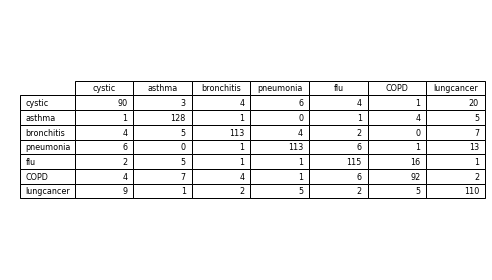

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

# hide axes

ax.axis('off')
ax.axis('tight')
labels = ['cystic', 'asthma', 'bronchitis', 'pneumonia', 'flu', 'COPD', 'lungcancer']
ax.table(cellText=confusion_matrix(valid_y, predictions), colLabels=labels, rowLabels =labels,  loc='center')
fig.tight_layout()

plt.show()

### Naiv Bayes - TF-IDF

In [30]:
classifier = naive_bayes.MultinomialNB()

classifier.fit(xtrain_tfidf, train_y)

predictions = classifier.predict(xvalid_tfidf)

metrics.accuracy_score(predictions, valid_y)

0.702355460385439

In [26]:
confusion_matrix(predictions, valid_y)

array([[ 49,   0,   3,   2,   2,   1,   6],
       [  4, 114,   0,   0,   2,   2,   0],
       [  5,   1,  97,   2,   2,   4,   5],
       [ 24,   2,  15, 117,  10,  21,  13],
       [  9,   2,   3,   7, 108,  19,   0],
       [  2,   5,   0,   0,  13,  63,   2],
       [ 35,  16,  17,  12,   4,   6, 108]], dtype=int64)

### Linear - word count

In [34]:
classifier = linear_model.LogisticRegression(solver='liblinear',multi_class='auto')

classifier.fit(xtrain_count, train_y)

predictions = classifier.predict(xvalid_count)

metrics.accuracy_score(predictions, valid_y)

0.7826552462526767

In [15]:
confusion_matrix(predictions, valid_y)

array([[117,   6,   2,   5,   2,  12,   2],
       [  3,  83,   4,   1,   3,  22,   2],
       [  1,   3, 115,   4,   3,   4,   3],
       [  3,  11,   3,  83,   9,  10,   3],
       [  3,   3,   5,   9, 116,   2,   2],
       [  6,  18,   9,   6,   5,  82,   5],
       [  2,   4,   2,   8,   3,   2, 123]], dtype=int64)

### Linear - TF-IDF

In [36]:
classifier = linear_model.LogisticRegression(solver='lbfgs')

classifier.fit(xtrain_tfidf, train_y)

predictions = classifier.predict(xvalid_tfidf)

metrics.accuracy_score(predictions, valid_y)

0.8147751605995718

In [17]:
confusion_matrix(predictions, valid_y)

array([[121,   4,   2,   4,   0,   8,   3],
       [  2,  96,   6,   2,   2,  17,   1],
       [  1,   5, 107,   7,   3,   5,   2],
       [  1,   7,   2,  85,  10,  10,   2],
       [  2,   1,   8,   8, 118,   1,   1],
       [  5,  14,  15,   4,   3,  92,   4],
       [  3,   1,   0,   6,   5,   1, 127]], dtype=int64)

### NLTK library

In [51]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import time
import random

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
word_count_dict = {}
start = time.time()
lemmatizer = WordNetLemmatizer() 

dp = display('Process started',display_id=True)
for index, row in all_pages.iterrows():
    words = re.split(' ', row['document'])
    
    for word in words:
        word = word.lower()
        if word not in set(stopwords.words('english')) and len(word) > 1:
            word = lemmatizer.lemmatize(word)
            if word not in word_count_dict:
                word_count_dict[word] = 1
            else:
                word_count_dict[word] = word_count_dict[word] + 1
    if index % 10 == 0:
        now = time.time()
        percent_ready = (index / all_pages.shape[0]) + 0.0000001
        dp.update('expected finish:'+ time.ctime(start + ((now-start) / percent_ready)))

'expected finish:Wed May 27 14:09:34 2020'

In [53]:
word_dict_list = sorted(word_count_dict.items(), key=lambda x: x[1], reverse = True)
words_shrinked = word_dict_list[0:6000]
word_list = [w for (w,n) in words_shrinked]

In [54]:
words_shrinked[0:15]

[('patient', 13439),
 ('study', 6693),
 ('disease', 6566),
 ('lung', 5326),
 ('cell', 4935),
 ('treatment', 4020),
 ('group', 3996),
 ('infection', 3872),
 ('asthma', 3700),
 ('respiratory', 3587),
 ('year', 3505),
 ('clinical', 3491),
 ('copd', 3166),
 ('associated', 3147),
 ('risk', 3145)]

In [55]:
def document_features(document):
    document_words = set(re.split(' ',document))
    features = {}
    for word in word_list:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [56]:
train_set = []
for ind, row in all_pages.iterrows():
    feature = (document_features(row['document']), row['category'])
    train_set.append(feature)
random.shuffle(train_set)

In [57]:
train_part = int(len(train_set)*0.85)

In [58]:
classifier_nb = nltk.NaiveBayesClassifier.train(train_set[0:train_part])

In [59]:
nltk.classify.accuracy(classifier_nb, train_set[train_part:len(train_set)])

0.6952789699570815

In [61]:
classifier_nb.show_most_informative_features(40)

Most Informative Features
        contains(cystic) = True           cystic : flu    =    239.4 : 1.0
    contains(bronchitis) = True           acuteb : flu    =    127.4 : 1.0
           contains(flu) = True              flu : lungca =    120.8 : 1.0
      contains(fibrosis) = True           cystic : flu    =    118.1 : 1.0
     contains(influenza) = True              flu : cystic =    117.2 : 1.0
 contains(bronchiolitis) = True           acuteb : flu    =    116.4 : 1.0
      contains(allergic) = True           asthma : lungca =    107.6 : 1.0
        contains(asthma) = True           asthma : pneumo =     94.4 : 1.0
 contains(transmembrane) = True           cystic : COPD   =     77.0 : 1.0
    contains(metastasis) = True           lungca : flu    =     76.0 : 1.0
   contains(vaccination) = True              flu : lungca =     75.3 : 1.0
   contains(conductance) = True           cystic : lungca =     73.6 : 1.0
    contains(aeruginosa) = True           cystic : flu    =     73.3 : 1.0